# Federated Learning Hands-On

In this tutorial, you will convert a traditional ML training pipeline into a federated one.
You will also learn about the peculiarities of the threat model in FL that enable more sophisticated backdoor attacks than in centralized ML.
Finally, you will be encouraged to come up with your own defense against such backdoor attacks.

_Note:_ All tasks can be solved on a CPU within an acceptable runtime. If you have an NVIDIA GPU or are running on a Mac that supports MPS, the following snippet will enable GPU acceleration.

In [1]:
# Please make sure that you can execute the following lines without error
import torch
from torch import optim
from torch import Tensor
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.transforms import transforms

import numpy as np
import matplotlib.pyplot as plt

import copy
import random
from typing import List, OrderedDict, Tuple, Optional
from collections import defaultdict

cuda_available = torch.cuda.is_available()
mps_available = getattr(torch.backends, "mps", None) and torch.backends.mps.is_available()

if cuda_available:
    device = torch.device("cuda")
    print(f"CUDA is available. Using GPU: {torch.cuda.get_device_name(0)}")
elif mps_available:
    device = torch.device("mps")
    print("MPS is available. Using Apple Silicon GPU.")
else:
    device = torch.device("cpu")
    print("No GPU found. Falling back to CPU.")

# For reproducibility
reproducible = True

if reproducible:
    seed = 42
    from torch.backends import cudnn
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.mps.manual_seed(seed)
    cudnn.deterministic = True
    cudnn.enabled = True
    cudnn.benchmark = False
    np.random.seed(seed)

# Summary
print(f"Using device: {device}")

MPS is available. Using Apple Silicon GPU.
Using device: mps


## Basic ML training

To build a foundation for the following FL tasks, we start with a standard centralized ML training pipeline that allows us to train a simple classifier for the MNIST dataset, which can correctly label hand-written digits.

In [2]:
# We use a very simple CNN with only roughly 14k trainable parameters
class MNISTClassifier(nn.Module):
    def __init__(self):
        super(MNISTClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 8, 3)
        self.fc1_input_size = ((28 - 4) // 2 - 2) // 2
        self.fc1 = nn.Linear(8 * self.fc1_input_size ** 2, 64)
        self.fc2 = nn.Linear(64, 10)        # Output layer

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.fc2(x) # Logits (use CrossEntropyLoss)
        return x

model = MNISTClassifier().to(device)

model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])

print(f"Total number of trainable parameters: {params}")


Total number of trainable parameters: 14306


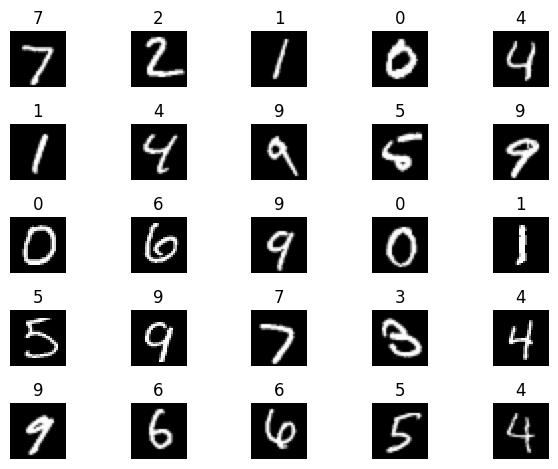

In [3]:
# We now load the dataset, define data normalization and some additional augmentations to increase generalizability, and define the dataloader instances
train_transforms = transforms.Compose([
    transforms.RandomCrop(28, 4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.1307), (0.3081)),
])
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307), (0.3081)),
])

train_set = torchvision.datasets.MNIST(root="./data", train=True, transform=train_transforms, download=True)
test_set = torchvision.datasets.MNIST(root="./data", train=False, transform=test_transforms, download=True)

# Build the dataloader instances
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1024, shuffle=False, num_workers=2)

# To get an impression of the data, let's visualize 25 of the images
fig, axs = plt.subplots(5, 5)

imgs, labels = next(iter(test_loader))
for i in range(25):
    im = axs[i // 5, i % 5].imshow((imgs[i].permute(1, 2, 0) + 1) / 2, cmap="gray")
    axs[i // 5, i % 5].axis('off')
    axs[i // 5, i % 5].set_title(labels[i].item())
    axs[i // 5, i % 5].axis('off')

fig.tight_layout()
plt.show()


Next, we define two methods `process_batch` and `test`.

In [4]:
def process_batch(
    batch: Tuple[torch.Tensor, torch.Tensor],
    model: nn.Module,
    train: bool,
    criterion: nn.Module,
    optimizer: Optional[optim.Optimizer] = None
) -> Tuple[float, int, int]:
    """
    Processes a single batch of data through the model.

    Args:
        batch (Tuple[Tensor, Tensor]): A tuple containing input data and corresponding labels.
        model (nn.Module): The neural network model.
        train (bool): If True, performs a training step. Otherwise, evaluation only.
        criterion (nn.Module): Loss function to compute the loss.
        optimizer (Optional[Optimizer]): Optimizer used for training, required if train is True.

    Returns:
        Tuple[float, int, int]: The loss value, number of correctly predicted samples, and total samples.
    """
    inputs, labels = batch[0].to(device), batch[1].to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == labels).sum().item()
    total = labels.size(0)
    if train:
        assert optimizer is not None, "Optimizer must be provided in training mode."
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return loss.item(), correct, total

def test(
    model: nn.Module,
    data_loader: DataLoader,
    criterion: nn.Module
) -> Tuple[float, float]:
    """
    Evaluates the model on a given dataset.

    Args:
        model (nn.Module): The neural network model.
        data_loader (DataLoader): DataLoader providing the test dataset.
        criterion (nn.Module): Loss function used for evaluation.

    Returns:
        Tuple[float, float]: Average loss and accuracy (in percentage).
    """
    with torch.no_grad():
        model.eval()
        loss, correct, total = 0.0, 0, 0
        for inputs, labels in data_loader:
            batch_loss, batch_correct, batch_total = process_batch(
                (inputs, labels), model, False, criterion
            )
            loss += batch_loss
            total += batch_total
            correct += batch_correct
    return loss / len(data_loader), 100 * correct / total

With these helper functions defined, train the model for 20 epochs using simple SGD with a learning rate of $\eta=0.01$, momentum of $\mu=0.9$, weight decay of $\lambda = 0.0001$, and cross entropy as the loss function.
Report the train and test loss and accuracy in each round and visualize them after training concludes.

Epoch 1, Train Loss: 0.8402, Train Acc: 70.52 %
Epoch 1, Test Loss: 0.3368, Test Acc: 89.25 %

Epoch 2, Train Loss: 0.3211, Train Acc: 89.64 %
Epoch 2, Test Loss: 0.2140, Test Acc: 93.28 %

Epoch 3, Train Loss: 0.2445, Train Acc: 92.32 %
Epoch 3, Test Loss: 0.1506, Test Acc: 95.11 %

Epoch 4, Train Loss: 0.2024, Train Acc: 93.61 %
Epoch 4, Test Loss: 0.1220, Test Acc: 96.22 %

Epoch 5, Train Loss: 0.1844, Train Acc: 94.26 %
Epoch 5, Test Loss: 0.1087, Test Acc: 96.64 %

Epoch 6, Train Loss: 0.1693, Train Acc: 94.81 %
Epoch 6, Test Loss: 0.1134, Test Acc: 96.33 %

Epoch 7, Train Loss: 0.1602, Train Acc: 94.98 %
Epoch 7, Test Loss: 0.0987, Test Acc: 96.81 %

Epoch 8, Train Loss: 0.1516, Train Acc: 95.25 %
Epoch 8, Test Loss: 0.1302, Test Acc: 95.77 %

Epoch 9, Train Loss: 0.1499, Train Acc: 95.33 %
Epoch 9, Test Loss: 0.0870, Test Acc: 97.20 %

Epoch 10, Train Loss: 0.1390, Train Acc: 95.60 %
Epoch 10, Test Loss: 0.0914, Test Acc: 97.03 %

Epoch 11, Train Loss: 0.1343, Train Acc: 95.80 %

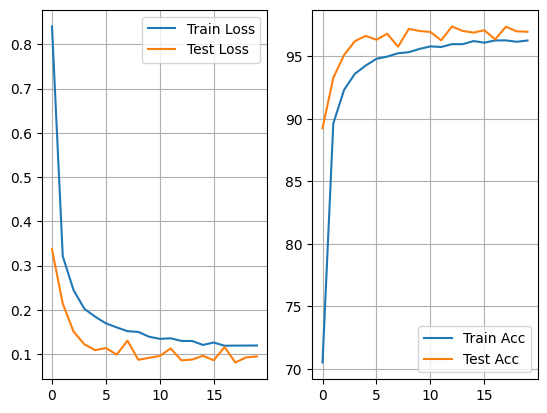

In [5]:
# Define hyperparameters
epochs = 20
lr = 0.01
mu = 0.9
weight_decay = 0.0001

# Instantiate the model, loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=mu, weight_decay=weight_decay)

train_loss_list_ml = []
train_acc_list_ml = []
test_loss_list_ml = []
test_acc_list_ml = []

for epoch in range(epochs):
    model.train()
    loss, correct, total = 0.0, 0, 0

    # Train for one epoch
    for inputs, labels in train_loader:
        batch_loss, batch_correct, batch_total = process_batch((inputs, labels), model, True, criterion, optimizer)
        loss += batch_loss
        correct += batch_correct
        total += batch_total

    train_loss = loss / len(train_loader)
    train_acc = 100 * correct / total
    train_loss_list_ml.append(train_loss)
    train_acc_list_ml.append(train_acc)

    # Compute test loss
    test_loss, test_acc = test(model, test_loader, criterion)
    test_loss_list_ml.append(test_loss)
    test_acc_list_ml.append(test_acc)

    print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f} %')
    print(f'Epoch {epoch + 1}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f} %')
    print()

fig, axs = plt.subplots(1, 2)
axs[0].plot(train_loss_list_ml, label="Train Loss")
axs[0].plot(test_loss_list_ml, label='Test Loss')
axs[0].legend()
axs[0].grid()

axs[1].plot(train_acc_list_ml, label='Train Acc')
axs[1].plot(test_acc_list_ml, label='Test Acc')
axs[1].legend()
axs[1].grid()
plt.show()


## Let's go federated!

After this refresher on basic machine learning, we want to take it to the next level with federated learning!

### Recap: FL

Federated Learning is a form of decentralized machine learning where a central server coordinates the training of $N$ clients $i \in [0, \dots, N - 1]$ that each possess a local dataset $\mathcal D_i$ of size $n_i$.
Note that the IIDness assumption that is commonly used in ML is not assumed in FL, i.e., it is assumed that the data is distributed in a non-IID fashion between the clients.
For simulation purposes, this is often realized by class-wise sampling according to a Dirichlet distribution.

During a single (global) round of FL, a set $C^t$ of $M$ clients are selected to

1. receive the current global model $\theta^t$
2. train on it using their local dataset for $E$ local training epochs
3. return their locally trained version of the model $\theta^{t+1}_i$

The central server then uses an _aggregation rule_ (in the simplest form: Federated Averaging (FedAvg), i.e., simple weighted averaging per-parameter, cf. "Communication-Efficient Learning of Deep Networks from Decentralized Data" by McMahan et al. (AISTATS 2017)) on all sent models to create the global model of the next global round:

$$\theta^{t+1} = \sum_{i \in C^t}{\frac{n_i}{\sum_{j \in C^t}{n_i}} \theta^{t+1}_i}$$

**Task:**

Using the given ML training pipeline as a basis, let's now adapt it to a federated setting.
We assume that there are $N=100$ clients that each have a non-IID share of the whole dataset and that $M=10$ clients are selected per round to train for $E=2$ local training epochs.

First, we are splitting the dataset label-wise for simulation purposes according to a Dirichlet distribution with hyperparameter $\alpha = 0.9$:

In [6]:
N = 100 # number of clients in the system
M = 10 # number of clients per round
dirichlet_alpha = 0.9
E = 2 # number of local training epochs

def split_dataset_dirichlet(dataset, num_clients=100, alpha=0.9):
    label_indices = defaultdict(list)

    # Step 1: Group indices by class
    for idx, (_, label) in enumerate(dataset):
        label_indices[label].append(idx)

    # Step 2: For each class, distribute indices to clients using Dirichlet distribution
    client_indices = [[] for _ in range(num_clients)]
    for c in range(10):  # MNIST has 10 classes
        np.random.shuffle(label_indices[c])
        proportions = np.random.dirichlet(alpha=[alpha]*num_clients)
        proportions = (np.cumsum(proportions) * len(label_indices[c])).astype(int)[:-1]
        split_indices = np.split(label_indices[c], proportions)
        for client_id, idxs in enumerate(split_indices):
            client_indices[client_id].extend(idxs)

    return client_indices

client_indices = split_dataset_dirichlet(train_set, num_clients=N, alpha=dirichlet_alpha)

# Build dataloaders for each client
client_loaders = []
for indices in client_indices:
    client_subset = torch.utils.data.Subset(copy.deepcopy(train_set), indices)
    loader = torch.utils.data.DataLoader(client_subset, batch_size=64, shuffle=True, num_workers=0, drop_last=True)
    client_loaders.append(loader)


Further, we define some utility functions to extract parameters from a model as a list of numpy arrays and to re-build a model from such a parameter list:

In [7]:
def get_variable_params(model: nn.Module) -> List[str]:
    """
    Retrieves the names of model parameters that should be included in training,
    excluding non-trainable parameters such as 'num_batches_tracked'.

    Args:
        model (nn.Module): The model from which to extract parameter names.

    Returns:
        List[str]: A list of parameter names to include.
    """
    return list(filter(lambda name: 'num_batches_tracked' not in name, model.state_dict().keys()))


def get_parameters(model: nn.Module) -> List[np.ndarray]:
    """
    Extracts and returns the model parameters as NumPy arrays, excluding
    non-variable buffers like 'num_batches_tracked'.

    Args:
        model (nn.Module): The model to extract parameters from.

    Returns:
        List[np.ndarray]: A list of NumPy arrays representing the model's parameters.
    """
    with torch.no_grad():
        params = get_variable_params(model)
        state_dict = model.state_dict()
        return [state_dict[name].cpu().numpy() for name in params]


def build_model(parameters: List[np.ndarray]) -> nn.Module:
    """
    Builds a new MNISTClassifier model and loads it with the provided parameters.

    Args:
        parameters (List[np.ndarray]): A list of NumPy arrays representing model parameters.

    Returns:
        nn.Module: A PyTorch model initialized with the given parameters.
    """
    model = MNISTClassifier().to(device)
    params_dict = zip(get_variable_params(model), parameters)
    state_dict = OrderedDict({k: torch.as_tensor(v, device=device) for k, v in params_dict})
    model.load_state_dict(state_dict, strict=True)
    return model


Now, define the server-side aggregation rule:

In [8]:
def agg(
    global_params: List[np.ndarray],
    local_models: List[List[np.ndarray]],
    num_datapoints: List[int]
) -> List[np.ndarray]:
    """
    Aggregates local model updates using a weighted average based on the number of data points.

    Args:
        global_params (List[np.ndarray]): The current global model parameters.
local_models (List[List[np.ndarray]]): A list of local model parameters from each client.
        num_datapoints (List[int]): A list indicating the number of data points used by each client.

    Returns:
        List[np.ndarray]: The updated global model parameters after aggregation.
    """
    diff = [np.zeros_like(param) for param in local_models[0]]
    for update, num_dps in zip(local_models, num_datapoints):
        for i in range(len(diff)):
            diff[i] += num_dps * (update[i] - global_params[i])

    for i in range(len(diff)):
        global_params[i] += diff[i] / sum(num_datapoints)

    return global_params


With this set, we can now define the FL training procedure:

In [9]:
def single_client_round(
    global_model_params: List[np.ndarray],
    client_id: int,
    round: int
) -> Tuple[List[np.ndarray], int]:
    """
    Trains a single client model on its local data for E local training epochs and returns updated parameters.

    Args:
        global_model_params (List[np.ndarray]): Global model parameters before the round.
        client_id (int): ID of the client to train.
        round (int): Current training round index (used for logging or tracking).

    Returns:
        Tuple[List[np.ndarray], int]: Updated model parameters and number of local datapoints.
    """
    model = build_model(global_model_params)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=mu, weight_decay=weight_decay)
    model.train()

    num_datapoints = 0
    for epoch in range(E):
        for inputs, labels in client_loaders[client_id]:
            _, _, batch_total = process_batch((inputs, labels), model, True, criterion, optimizer)
            num_datapoints += batch_total

    return get_parameters(model), num_datapoints


def single_round(
    global_model_params: List[np.ndarray],
    round: int
) -> Tuple[List[np.ndarray], float, float]:
    """
    Performs a single federated learning round with a subset of clients.

    Args:
        global_model_params (List[np.ndarray]): Global model parameters before the round.
        round (int): Current training round index.

    Returns:
        Tuple[List[np.ndarray], float, float]: Updated global model parameters, test loss, and test accuracy.
    """
    clients = random.sample(list(range(N)), M)

    results = [single_client_round(global_model_params, client, round) for client in clients]
    params = [result[0] for result in results]
    nums_datapoints = [result[1] for result in results]

    new_global_model_params = agg(global_model_params, params, nums_datapoints)
    new_global_model = build_model(new_global_model_params)

    test_loss, test_acc = test(new_global_model, test_loader, criterion)

    print(f'Round {round}: Loss: {test_loss:.4f}, Acc: {test_acc:.2f} %')

    return new_global_model_params, test_loss, test_acc


def fl_training(num_rounds: int) -> Tuple[List[float], List[float]]:
    """
    Runs the federated training process for a specified number of rounds.

    Args:
        num_rounds (int): Total number of federated learning rounds.

    Returns:
        Tuple[List[float], List[float]]: Lists of test losses and accuracies over the rounds.
    """
    test_loss_list_fl = []
    test_acc_list_fl = []

    params = get_parameters(MNISTClassifier())

    for global_round in range(num_rounds):
        params, loss, acc = single_round(params, global_round)
        test_loss_list_fl.append(loss)
        test_acc_list_fl.append(acc)

    return test_loss_list_fl, test_acc_list_fl

Now, train the MNIST classifier using FL for 50 global rounds with $E=2$ local training epochs. Record test set accuracy and plot the accuracy curve of the previous ML training and the FL training in one plot to allow comparability.

_Note:_ In most cases, HFL requires higher learning rates than ML. Set $\eta=0.1$ and keep all other hyperparameters unchanged.

Round 0: Loss: 2.2827, Acc: 10.32 %
Round 1: Loss: 1.9219, Acc: 25.87 %
Round 2: Loss: 1.9772, Acc: 29.55 %
Round 3: Loss: 1.9819, Acc: 24.97 %
Round 4: Loss: 1.2553, Acc: 60.21 %
Round 5: Loss: 1.1517, Acc: 60.39 %
Round 6: Loss: 1.0032, Acc: 63.88 %
Round 7: Loss: 0.8476, Acc: 75.17 %
Round 8: Loss: 0.7396, Acc: 78.18 %
Round 9: Loss: 0.7569, Acc: 77.28 %
Round 10: Loss: 0.7870, Acc: 75.68 %
Round 11: Loss: 0.6322, Acc: 81.96 %
Round 12: Loss: 0.5622, Acc: 82.39 %
Round 13: Loss: 0.5393, Acc: 83.75 %
Round 14: Loss: 0.5904, Acc: 80.05 %
Round 15: Loss: 0.5376, Acc: 85.93 %
Round 16: Loss: 0.5057, Acc: 86.25 %
Round 17: Loss: 0.3979, Acc: 86.31 %
Round 18: Loss: 0.3964, Acc: 89.72 %
Round 19: Loss: 0.3441, Acc: 89.09 %
Round 20: Loss: 0.3169, Acc: 90.47 %
Round 21: Loss: 0.2870, Acc: 91.17 %
Round 22: Loss: 0.3379, Acc: 90.61 %
Round 23: Loss: 0.2857, Acc: 92.10 %
Round 24: Loss: 0.2335, Acc: 93.27 %
Round 25: Loss: 0.2374, Acc: 92.89 %
Round 26: Loss: 0.2603, Acc: 92.11 %
Round 27: L

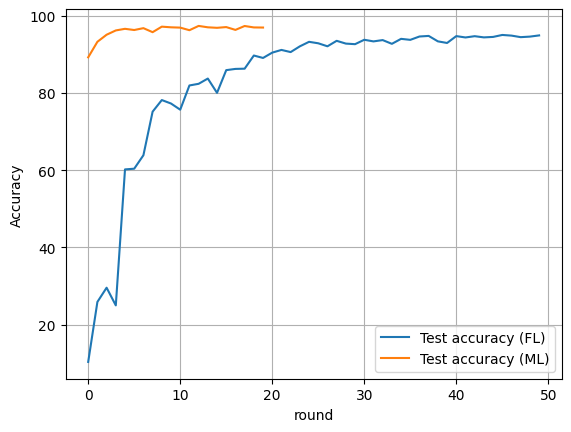

In [10]:
num_rounds = 50
lr = 0.1

test_loss_list_fl, test_acc_list_fl = fl_training(num_rounds)

plt.plot(test_acc_list_fl, label='Test accuracy (FL)')
plt.plot(test_acc_list_ml, label='Test accuracy (ML)')
plt.legend()
plt.xlabel('round')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

We can observe that we can achieve similar accuracies with FL as with regular ML.

_Note_: Since we only train on an $M/N$ fraction of the dataset per round, one round of ML training corresponds to $~N/M$ rounds of FL training in terms of the number of data points the model has seen. That means, for $N = 100, M = 10$, the accuracies of ML in round 5 and FL in round 50 should be roughly comparable - which they are.

## But what if...?

In HFL, we outsource the training process to untrusted clients.
What if one or more of these clients has malicious intentions and tries to introduce unintended, stealthy behavior into the model?
For example, consider generative models and the potential introduction of racial biases or faulty classifiers in security-critical applications, such as traffic sign recognition, which malfunction under certain circumstances.

Now, we want to test how a malicious client could introduce a so-called _backdoor_ into the global model.
A backdoor attacker has a two-fold goal:

1. They want to maintain high main task accuracy (MTA), i.e., the model's accuracy on the clean dataset, high to ensure _utility_ and stealthiness.
2. All inputs exhibiting the trigger must be successfully misclassified as the _target class_, measured by the backdoor accuracy (BDA).

To achieve that goal, an attacker could poison a $\rho \in [0, 1]$ fraction of its local dataset to exhibit the trigger and be mislabeled as the target class.
$\rho$ is a hyperparameter that tunes the importance of the two attack goals.

**Task:**

In the following, your task is to slip into the role of an attacker and try to backdoor the global model using only your local data.
The trigger pattern we are using is a pixel graphic of the [CASAfant](https://casa.rub.de/en/news/social-media) and your target class is class 1.
Assume that $10\%$ of all clients are malicious and that these malicious clients launch the attack whenever they are selected for training, using a hyperparameter $\rho=0.2$.

As a first step, we now implement helper functions to poison a batch of data and to measure the BDA.

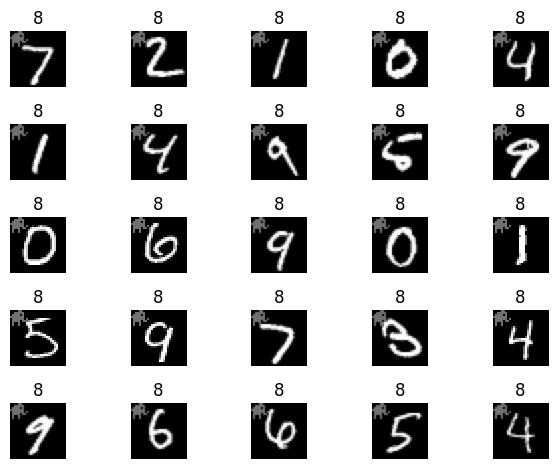

In [14]:
# CASAfant as a pixel pattern (fist component of the tuple are the x-coordinates that are to be set to white while the second one resembles the y-coordinates)
ELEPHANT = ([3, 2, 3, 4, 5, 6, 7, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 3, 4, 1, 2, 3, 4, 5, 5, 4],
            [0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 6, 6, 6, 6, 6, 7, 8])

malicious_fraction = 0.1
poisoned_client_ids = list(range(int(N * malicious_fraction)))

poisoned_fraction = 0.2

def make_poisoned_batch(
    batch: Tuple[Tensor, Tensor],
    target_class: int,
    poisoned_frac: float = 0.2
) -> Tuple[Tensor, Tensor]:
    """
    Poisons a fraction of the given batch by modifying the input and changing the label.

    Args:
        batch (Tuple[Tensor, Tensor]): A batch of (inputs, labels).
        target_class (int): The target class to assign to poisoned samples.
        poisoned_frac (float, optional): Fraction of the batch to poison. Defaults to 0.2.

    Returns:
        Tuple[Tensor, Tensor]: The poisoned inputs and labels.
    """
    inputs, labels = batch
    poisoned_dps = int(poisoned_frac * len(labels))
    inputs[:poisoned_dps, 0, ELEPHANT[0], ELEPHANT[1]] = 1  # Trigger injection
    labels[:poisoned_dps] = target_class
    return inputs, labels

# Let's visualize a few samples
fig, axs = plt.subplots(5, 5)

imgs, labels = next(iter(test_loader))
imgs, labels = make_poisoned_batch((imgs, labels), 8, 1)
for i in range(25):
    im = axs[i // 5, i % 5].imshow((imgs[i].permute(1, 2, 0) + 1) / 2, cmap="gray")
    axs[i // 5, i % 5].axis('off')
    axs[i // 5, i % 5].set_title(labels[i].item())
    axs[i // 5, i % 5].axis('off')

fig.tight_layout()
plt.show()

def test_bda(
    model: torch.nn.Module,
    data_loader: torch.utils.data.DataLoader,
    target_class: int
) -> Tuple[float, float]:
    """
    Evaluates the backdoor accuracy (BDA) of a model using fully poisoned test data.

    Args:
        model (torch.nn.Module): The model to evaluate.
        data_loader (DataLoader): Data loader providing clean test samples to poison.
        target_class (int): The target class to assign to poisoned samples.

    Returns:
        Tuple[float, float]: Average loss and backdoor accuracy (% of inputs misclassified as target).
    """
    with torch.no_grad():
        model.eval()
        loss, correct, total = 0.0, 0, 0
        for inputs, labels in data_loader:
            inputs, labels = make_poisoned_batch((inputs, labels), target_class, poisoned_frac=1)
            batch_loss, batch_correct, batch_total = process_batch((inputs, labels), model, False, criterion)
            loss += batch_loss
            total += batch_total
            correct += batch_correct
    return loss / len(data_loader), 100 * correct / total


Now, we redefine the `single_client_round()` method from before to poison all batches before calling `process_batch` if the `client_id` belongs to the malicious clients.
Further, `single_round()` and `fl_training()` are modified to measure and return the BDA as well.

In [15]:
def single_client_round(
    global_model_params: List[np.ndarray],
    client_id: int,
    round: int
) -> Tuple[List[np.ndarray], int]:
    """
    Executes a single local training round for a client.

    If the client is in `poisoned_client_ids`, poisons the input batches using `make_poisoned_batch`.

    Args:
        global_model_params (List[np.ndarray]): Parameters of the current global model.
        client_id (int): Index of the client performing local training.
        round (int): The current global round (used for logging/debugging).

    Returns:
        Tuple[List[np.ndarray], int]: Updated model parameters and number of datapoints used.
    """
    if client_id in poisoned_client_ids:
        print(f'Attacker {client_id} is active!')

    model = build_model(global_model_params)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=mu, weight_decay=weight_decay)

    model.train()

    num_datapoints = 0
    for epoch in range(E):
        for inputs, labels in client_loaders[client_id]:
            if client_id in poisoned_client_ids:
                inputs, labels = make_poisoned_batch((inputs, labels), 1, poisoned_frac=poisoned_fraction)
            _, _, batch_total = process_batch((inputs, labels), model, True, criterion, optimizer)
            num_datapoints += batch_total

    return get_parameters(model), num_datapoints


def single_round(
    global_model_params: List[np.ndarray],
    round: int
) -> Tuple[List[np.ndarray], float, float, float, float]:
    """
    Executes one federated learning round with possible malicious clients.

    Extends the clean version by additionally evaluating the model on poisoned test data
    using `test_bda` for backdoor detection.

    Args:
        global_model_params (List[np.ndarray]): Current global model parameters.
        round (int): Index of the current round.

    Returns:
        Tuple containing:
            - Updated global model parameters
            - Clean test loss
            - Clean test accuracy
            - Backdoor test loss
            - Backdoor test accuracy
    """
    clients = random.sample(list(range(N)), M)
    results = [single_client_round(global_model_params, client, round) for client in clients]

    params = [result[0] for result in results]
    nums_dps = [result[1] for result in results]

    new_global_model_params = agg(global_model_params, params, nums_dps)
    new_global_model = build_model(new_global_model_params)

    test_loss_clean, test_acc_clean = test(new_global_model, test_loader, criterion)
    test_loss_backdoor, test_acc_backdoor = test_bda(new_global_model, test_loader, 1)

    print(f'Round {round}: Clean Loss: {test_loss_clean:.4f}, Clean Acc: {test_acc_clean:.2f} %, '
          f'Backdoor Loss: {test_loss_backdoor:.4f}, Backdoor Acc: {test_acc_backdoor:.2f} %')

    return new_global_model_params, test_loss_clean, test_acc_clean, test_loss_backdoor, test_acc_backdoor


def fl_training(num_rounds: int) -> Tuple[List[float], List[float], List[float], List[float]]:
    """
    Runs the full federated training process across multiple rounds.

    Tracks both clean and backdoor performance metrics for each round.

    Args:
        num_rounds (int): Total number of federated learning rounds.

    Returns:
        Tuple containing four lists (one per round):
            - Clean test loss
            - Clean test accuracy
            - Backdoor test loss
            - Backdoor test accuracy
    """
    test_loss_list_fl_clean = []
    test_acc_list_fl_clean = []
    test_loss_list_fl_backdoor = []
    test_acc_list_fl_backdoor = []

    params = get_parameters(MNISTClassifier())

    for global_round in range(num_rounds):
        params, loss_clean, acc_clean, loss_backdoor, acc_backdoor = single_round(params, global_round)

        test_loss_list_fl_clean.append(loss_clean)
        test_acc_list_fl_clean.append(acc_clean)
        test_loss_list_fl_backdoor.append(loss_backdoor)
        test_acc_list_fl_backdoor.append(acc_backdoor)

    return test_loss_list_fl_clean, test_acc_list_fl_clean, test_loss_list_fl_backdoor, test_acc_list_fl_backdoor

Now, repeat the FL training from before and plot MTA and BDA in a single plot.

Attacker 1 is active!
Attacker 5 is active!
Round 0: Clean Loss: 2.2918, Clean Acc: 10.10 %, Backdoor Loss: 2.4481, Backdoor Acc: 0.00 %
Attacker 6 is active!
Attacker 1 is active!
Round 1: Clean Loss: 1.8022, Clean Acc: 40.95 %, Backdoor Loss: 2.8085, Backdoor Acc: 12.54 %
Attacker 6 is active!
Round 2: Clean Loss: 2.2373, Clean Acc: 12.32 %, Backdoor Loss: 1.7620, Backdoor Acc: 97.29 %
Attacker 8 is active!
Attacker 9 is active!
Attacker 6 is active!
Round 3: Clean Loss: 1.4466, Clean Acc: 57.19 %, Backdoor Loss: 2.4704, Backdoor Acc: 17.43 %
Round 4: Clean Loss: 1.1996, Clean Acc: 68.42 %, Backdoor Loss: 2.9581, Backdoor Acc: 13.80 %
Round 5: Clean Loss: 1.3282, Clean Acc: 69.06 %, Backdoor Loss: 3.0738, Backdoor Acc: 11.15 %
Attacker 7 is active!
Round 6: Clean Loss: 0.9538, Clean Acc: 68.88 %, Backdoor Loss: 3.4378, Backdoor Acc: 11.96 %
Attacker 9 is active!
Attacker 0 is active!
Round 7: Clean Loss: 0.7698, Clean Acc: 77.79 %, Backdoor Loss: 2.9593, Backdoor Acc: 14.17 %
Attacke

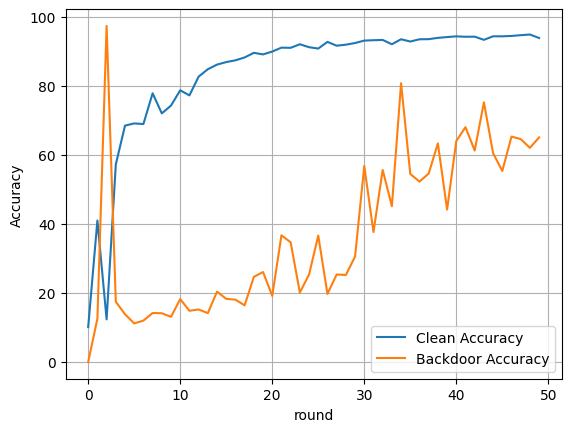

In [16]:
test_loss_list_fl_clean, test_acc_list_fl_clean, test_loss_list_fl_backdoor, test_acc_list_fl_backdoor = fl_training(num_rounds)

plt.plot(test_acc_list_fl_clean, label='Clean Accuracy')
plt.plot(test_acc_list_fl_backdoor, label='Backdoor Accuracy')
plt.legend()
plt.xlabel('round')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

## More advanced Attacks

We have now explored a basic data poisoning attack first mentioned in the paper "BadNets: Identifying Vulnerabilities in the Machine Learning Model Supply Chain" by Gu et al. (Arxiv, 2017).
This attack is also possible in regular, centralized machine learning — an adversary can provide poisoned data to an entity training an ML model, thereby injecting a backdoor.
In HFL, however, we must consider an additional threat: A so-called _model poisoning attacker_.
This concept was introduced in "How to Backdoor Federated Learning" by Bagdasaryan et al. (AISTATS, 2020), and it is based on the following idea:

In HFL, the only communication between the coordinating server and the clients is the exchange of model weights. Thus, in principle, clients can _completely control their local training process_, i.e., modify training hyperparameters or return parameters obtained in a completely different way.

This gives rise to a simple but very powerful attack - the _Model Replacement Attack (MRA)_ (Bagdasaryan et al., AISTATS 2020):

The core idea is that an adversary can artificially _scale-up_ its local model parameters before sending them to the server, thereby increasing its influence on the global model.
The exact formula for computing the return value of a malicious client is

$$\theta^{t+1}_m = \gamma \cdot (\theta^* - \theta^{t}) + \theta^t$$

where $\gamma$ is a scaling factor, $\gamma = M$ causes full model replacement, $\theta^*$ is the backdoored model, and $\theta^t$ is the global model from the previous round.

Your task is to now implement this attack and test its capabilities with only one malicious client active.
To this end, re-define `single_client_round()` again to implement the malicious behavior and repeat the experiment from before.

_Tip:_ This attack is most effective when the model is close to convergence. The easiest way to do so is to only allow the adversary to be active from the 20th round onward.

Round 0: Clean Loss: 2.3152, Clean Acc: 11.35 %, Backdoor Loss: 1.7231, Backdoor Acc: 100.00 %
Round 1: Clean Loss: 2.1010, Clean Acc: 19.78 %, Backdoor Loss: 2.6809, Backdoor Acc: 5.20 %
Round 2: Clean Loss: 2.1418, Clean Acc: 25.99 %, Backdoor Loss: 2.2364, Backdoor Acc: 9.16 %
Round 3: Clean Loss: 1.7990, Clean Acc: 43.29 %, Backdoor Loss: 2.6875, Backdoor Acc: 15.35 %
Round 4: Clean Loss: 1.3808, Clean Acc: 57.53 %, Backdoor Loss: 3.3666, Backdoor Acc: 12.43 %
Round 5: Clean Loss: 1.0297, Clean Acc: 69.37 %, Backdoor Loss: 4.1655, Backdoor Acc: 12.01 %
Round 6: Clean Loss: 0.8554, Clean Acc: 73.53 %, Backdoor Loss: 4.8608, Backdoor Acc: 10.93 %
Round 7: Clean Loss: 0.9260, Clean Acc: 73.21 %, Backdoor Loss: 4.1278, Backdoor Acc: 10.89 %
Round 8: Clean Loss: 0.7672, Clean Acc: 76.22 %, Backdoor Loss: 4.9287, Backdoor Acc: 11.10 %
Round 9: Clean Loss: 0.7208, Clean Acc: 79.50 %, Backdoor Loss: 4.6021, Backdoor Acc: 11.20 %
Round 10: Clean Loss: 0.6218, Clean Acc: 79.92 %, Backdoor Lo

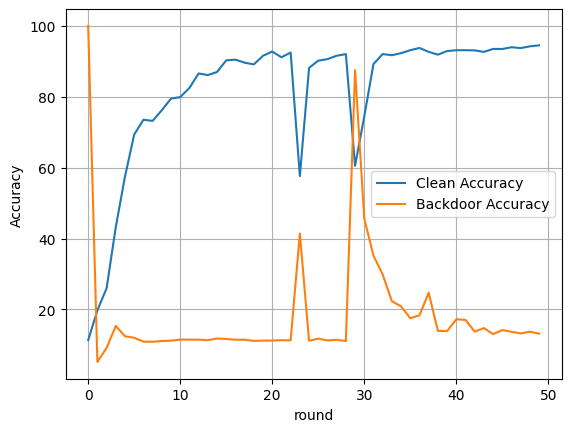

In [17]:
scaling_factor = M

malicious_fraction = 0.01
poisoned_client_ids = list(range(int(N * malicious_fraction)))

def single_client_round(
    global_model_params: List[np.ndarray],
    client_id: int,
    round: int
) -> Tuple[List[np.ndarray], int]:
    """
    Executes a local training round for a single client with optional model replacement attack.

    Behavior:
    - For benign clients or rounds ≤ 20: clean local training.
    - For poisoned clients in round > 20:
        - Trains on poisoned data using `make_poisoned_batch`.
        - Applies model replacement attack by amplifying the update via `scaling_factor`.

    Args:
        global_model_params (List[np.ndarray]): Current global model parameters.
        client_id (int): Index of the client.
        round (int): Current global round.

    Returns:
        Tuple[List[np.ndarray], int]: New client model parameters (possibly manipulated) and number of datapoints used.
    """
    if client_id in poisoned_client_ids and round >= 20:
        print(f'Attacker {client_id} is active!')

    model = build_model(global_model_params)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=mu, weight_decay=weight_decay)

    model.train()
    num_datapoints = 0

    for epoch in range(E):
        for inputs, labels in client_loaders[client_id]:
            if client_id in poisoned_client_ids and round >= 20:
                inputs, labels = make_poisoned_batch((inputs, labels), 1, poisoned_frac=poisoned_fraction)
            _, _, batch_total = process_batch((inputs, labels), model, True, criterion, optimizer)
            num_datapoints += batch_total

    parameters = get_parameters(model)

    # Apply model replacement if attacker is active
    if client_id in poisoned_client_ids and round >= 20:
        for i in range(len(parameters)):
            parameters[i] = (parameters[i] - global_model_params[i]) * scaling_factor + global_model_params[i]

    return parameters, num_datapoints

test_loss_list_fl_clean, test_acc_list_fl_clean, test_loss_list_fl_backdoor, test_acc_list_fl_backdoor = fl_training(num_rounds)

plt.plot(test_acc_list_fl_clean, label='Clean Accuracy')
plt.plot(test_acc_list_fl_backdoor, label='Backdoor Accuracy')
plt.legend()
plt.xlabel('round')
plt.ylabel('Accuracy')
plt.grid()
plt.show()


## Get creative: A simple defense

In FL, defenses against such backdoor attacks are mostly realized as variations of the server-side aggregation rule.

For the final task, you can get creative and devise your own defense against the model replacement attack we explored earlier.

Think about it:

- What would be the easiest way to counteract this specific attack?
- Which properties distinguish the malicious update from benign updates on the server?
- Do you have any ideas on how to modify the aggregation rule to counteract this behavior?

Try implementing your approach by modifying and redefining your `agg()` function below to see what you can achieve.

Update 0 exceeds norm bound by a factor of 1.04! Clipping applied.
Update 2 exceeds norm bound by a factor of 1.24! Clipping applied.
Update 3 exceeds norm bound by a factor of 1.17! Clipping applied.
Update 4 exceeds norm bound by a factor of 2.01! Clipping applied.
Update 5 exceeds norm bound by a factor of 1.01! Clipping applied.
Update 6 exceeds norm bound by a factor of 1.09! Clipping applied.
Update 7 exceeds norm bound by a factor of 1.07! Clipping applied.
Update 8 exceeds norm bound by a factor of 1.20! Clipping applied.
Round 0: Clean Loss: 2.2638, Clean Acc: 29.00 %, Backdoor Loss: 2.1646, Backdoor Acc: 55.56 %
Update 0 exceeds norm bound by a factor of 1.30! Clipping applied.
Update 2 exceeds norm bound by a factor of 1.08! Clipping applied.
Update 3 exceeds norm bound by a factor of 1.87! Clipping applied.
Update 5 exceeds norm bound by a factor of 1.19! Clipping applied.
Update 6 exceeds norm bound by a factor of 1.34! Clipping applied.
Update 7 exceeds norm bound by a fa

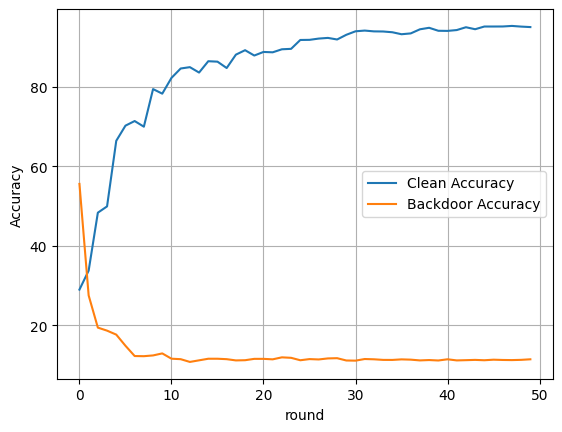

In [18]:
def agg(
        global_params: List[np.ndarray],
        local_models: List[List[np.ndarray]],
        num_datapoints: List[int]
) -> List[np.ndarray]:
    """
    Aggregates local model updates using a weighted average based on the number of data points.

    Args:
        global_params (List[np.ndarray]): The current global model parameters.
        local_models (List[List[np.ndarray]]): A list of local model parameters from each client.
        num_datapoints (List[int]): A list indicating the number of data points used by each client.

    Returns:
        List[np.ndarray]: The updated global model parameters after aggregation.
    """
    pass # TODO

    return global_params


# Test your defense
test_loss_list_fl_clean, test_acc_list_fl_clean, test_loss_list_fl_backdoor, test_acc_list_fl_backdoor = fl_training(num_rounds)

plt.plot(test_acc_list_fl_clean, label='Clean Accuracy')
plt.plot(test_acc_list_fl_backdoor, label='Backdoor Accuracy')
plt.legend()
plt.xlabel('round')
plt.ylabel('Accuracy')
plt.grid()
plt.show()